<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/Metrics_complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
import json
import matplotlib.pyplot as plt
import networkx as nx
import timeit

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [66]:
def cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim


def graph_from_df(df):
  # Build graph to calculate degree of centrality:

  df['login'] = df['login'].apply(lambda x: 'User: '+x)
  df['name'] = df['name'].apply(lambda x: 'Repo: '+x)

  # Build the adjacency matrix
  am = pd.crosstab(df['login'], df['name']).astype(float)
  idx = am.columns.union(am.index)
  am = am.reindex(index = idx, columns=idx, fill_value=0.0)

  matrix_elements = np.sort(df['login'].unique(), axis=0)
  repo_len = len(df['name'].unique())

  #Initialise an auxiliar matrix to record the user - user similarities
  shape = (len(matrix_elements), len(matrix_elements))
  aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

  for i in matrix_elements:
      for j in matrix_elements:

          # Compare row vectors
          aux_vector_a = am.loc[i].to_numpy()[:repo_len]
          aux_vector_b = am.loc[j].to_numpy()[:repo_len]
          
          score = cosine_similarity(aux_vector_a, aux_vector_b)
          # print(i, j, score)
          aux_matrix.at[i, j] = score

  #%%
  # Fill adj_matrix with aux_matrix data
  for column in aux_matrix.columns:
      for row in aux_matrix.index:

          aux = aux_matrix.at[row, column]
          am.at[row, column] = aux
          # if (aux == am.at[row, column]) ==  False:
          #     print(aux, row, column)

  # %%
  # Build graph from matrix, after user-user connections
  G = nx.from_pandas_adjacency(am)

  return G

def centrality_measures_to_df(data, centrality_name):
    df = pd.DataFrame(data, columns=['Node', centrality_name])
    return df

def raw_centrality_timings(G):

  start_time = timeit.default_timer()
  nx.degree_centrality(G)
  dc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.closeness_centrality(G)
  cc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.eigenvector_centrality(G, max_iter=1000) # add max_iter The default value is 100 cycles.
  ec_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.pagerank(G)
  pr_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  nx.hits(G,max_iter=120)
  ha_time = timeit.default_timer() - start_time

  return [dc_time, cc_time, ec_time, pr_time, ha_time]

def to_df_centrality_timings(G):

  start_time = timeit.default_timer()
  centrality_measures_to_df(sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Degree_centrality')
  dc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(sorted(nx.closeness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Closeness_centrality')
  cc_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(sorted(  nx.eigenvector_centrality(G, max_iter=1000).items(), key=lambda x:x[1], reverse=True), 'Eigenvector_centrality') # add max_iter The default value is 100 cycles.
  ec_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  centrality_measures_to_df(sorted(nx.pagerank(G).items(), key=lambda x:x[1], reverse=True), 'Pagerank')
  pr_time = timeit.default_timer() - start_time

  start_time = timeit.default_timer()
  hub, auth = nx.hits(G,max_iter=120)
  centrality_measures_to_df(sorted(hub.items(), key=lambda x:x[1], reverse=True), 'Hubs')
  centrality_measures_to_df(sorted(auth.items(), key=lambda x:x[1], reverse=True), 'Authorities')
  ha_time = timeit.default_timer() - start_time

  return [dc_time, cc_time, ec_time, pr_time, ha_time]

In [67]:
df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv')
df

,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files
0,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:38:18 UTC,"{""action"":""closed"",""number"":3,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
1,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:28:12 UTC,"{""action"":""opened"",""number"":3,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
2,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 16:19:54 UTC,"{""action"":""closed"",""number"":4,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
3,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:37:56 UTC,"{""action"":""opened"",""number"":4,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
4,PullRequestEvent,mavimaec,vimaec/g3d,2021-11-19 20:40:52 UTC,"{""action"":""closed"",""number"":8,""pull_request"":{...","""COBOL""","""closed""","""mavimaec""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/8""",2,113,702,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-05-14 03:43:29 UTC,"{""action"":""closed"",""number"":115,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,688,1,39
1329,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-06 17:56:00 UTC,"{""action"":""closed"",""number"":127,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1330,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-11-30 22:12:33 UTC,"{""action"":""opened"",""number"":127,""pull_request""...","""COBOL""","""opened""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1331,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-09 04:01:35 UTC,"{""action"":""closed"",""number"":128,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,5,1,1


In [ ]:
input_size = []
build_graph_timing = []

In [68]:
input_size.append(df.shape[0])

start_time = timeit.default_timer()
G = graph_from_df(df)
build_graph_timing.append(timeit.default_timer() - start_time)

cobol_raw_timings = raw_centrality_timings(G)
cobol_to_df_timings = to_df_centrality_timings(G)

In [69]:
df = pd.read_csv('/content/drive/MyDrive/Socialz/pascal_pullrequests.csv')
df

,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files,merged,comments,review_comments
0,PullRequestEvent,User756675678,User756675678/HeidiSQL,2021-02-04 13:04:34 UTC,"{""action"":""opened"",""number"":10,""pull_request"":...","""Pascal""","""opened""","""User756675678""","""User""","""https://api.github.com/repos/User756675678/He...",2,27,10,2,False,0,0
1,PullRequestEvent,hkollmann,TurboPack/Orpheus,2021-12-03 13:35:09 UTC,"{""action"":""opened"",""number"":30,""pull_request"":...","""Pascal""","""opened""","""hkollmann""","""User""","""https://api.github.com/repos/TurboPack/Orpheu...",4,213,67,9,False,0,0
2,PullRequestEvent,tebe6502,tebe6502/Mad-Pascal,2021-02-09 15:29:29 UTC,"{""action"":""closed"",""number"":19,""pull_request"":...","""Pascal""","""closed""","""zbyti""","""User""","""https://api.github.com/repos/tebe6502/Mad-Pas...",1,2,2,1,True,0,0
3,PullRequestEvent,hdxrie,royqh1979/Dev-CPP,2021-02-26 02:51:21 UTC,"{""action"":""opened"",""number"":154,""pull_request""...","""Pascal""","""opened""","""hdxrie""","""User""","""https://api.github.com/repos/royqh1979/Dev-CP...",1,0,0,92,False,0,0
4,PullRequestEvent,rpottsoh,exercism/delphi,2021-10-04 16:36:15 UTC,"{""action"":""closed"",""number"":471,""pull_request""...","""Pascal""","""closed""","""exercism-bot""","""User""","""https://api.github.com/repos/exercism/delphi/...",1,5,0,1,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16442,PullRequestEvent,salvadorbs,salvadorbs/Asuite,2021-08-07 16:09:38 UTC,"{""action"":""closed"",""number"":115,""pull_request""...","""Pascal""","""closed""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/salvadorbs/Asuit...",1,83,15,1,True,0,0
16443,PullRequestEvent,pyscripter,pyscripter/pyscripter,2021-01-19 15:09:17 UTC,"{""action"":""closed"",""number"":1054,""pull_request...","""Pascal""","""closed""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/pyscripter/pyscr...",1,5,1,1,True,0,0
16444,PullRequestEvent,pyscripter,pyscripter/pyscripter,2021-01-19 15:10:00 UTC,"{""action"":""closed"",""number"":1057,""pull_request...","""Pascal""","""closed""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/pyscripter/pyscr...",1,88,0,1,False,1,0
16445,PullRequestEvent,transifex-integration[bot],pyscripter/pyscripter,2021-01-19 15:24:59 UTC,"{""action"":""opened"",""number"":1083,""pull_request...","""Pascal""","""opened""","""transifex-integration[bot]""","""Bot""","""https://api.github.com/repos/pyscripter/pyscr...",1,0,0,0,False,0,0


In [70]:
input_size.append(df.shape[0])

start_time = timeit.default_timer()
G = graph_from_df(df)
build_graph_timing.append(timeit.default_timer() - start_time)

pascal_raw_timings = raw_centrality_timings(G)
pascal_to_df_timings = to_df_centrality_timings(G)

In [75]:
input_size

[1333, 16447]

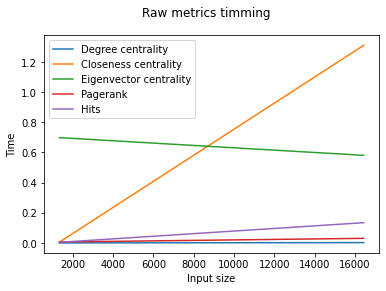

In [88]:
dc_time = [cobol_raw_timings[0],pascal_raw_timings[0]]
cc_time = [cobol_raw_timings[1],pascal_raw_timings[1]]
ec_time = [cobol_raw_timings[2],pascal_raw_timings[2]]
pr_time = [cobol_raw_timings[3],pascal_raw_timings[3]]
ha_time = [cobol_raw_timings[4],pascal_raw_timings[4]]

[dc_time, cc_time, ec_time, pr_time, ha_time]

plt.plot(input_size, dc_time, label='Degree centrality')
plt.plot(input_size, cc_time, label='Closeness centrality')
plt.plot(input_size, ec_time, label='Eigenvector centrality')
plt.plot(input_size, pr_time, label='Pagerank')
plt.plot(input_size, ha_time, label='Hits')
plt.legend()
plt.suptitle('Raw metrics timming')
plt.xlabel('Input size')
plt.ylabel('Time')
plt.show()